<a href="https://colab.research.google.com/github/mvelazco12/projekt_cienciadatos/blob/main/propyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cargar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import zipfile
import kagglehub
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!pip install kagglehub

In [4]:
drive.mount('/content/drive')

path_dataset="/content/drive/MyDrive/dataset"

Mounted at /content/drive


In [5]:
train_dir = os.path.join(path_dataset, "train")
val_dir = os.path.join(path_dataset, "test")

In [6]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
# Parámetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

preprocess_input = keras.applications.vgg16.preprocess_input

# Cargar los datos con preprocesamiento
train_data = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

val_data = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,

)
class_names = train_data.class_names

train_data = train_data.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))
val_data = val_data.map(lambda x, y: (x, tf.expand_dims(y, axis=-1)))



Found 2032 files belonging to 2 classes.
Found 407 files belonging to 2 classes.


In [8]:
for images, labels in train_data.take(1):
    print("Forma de las imágenes:", images.shape)
    print("Forma de las etiquetas:", labels.shape)
for images, labels in train_data.take(1):
    print("Etiquetas del batch:", labels.numpy())


Forma de las imágenes: (32, 224, 224, 3)
Forma de las etiquetas: (32, 1)
Etiquetas del batch: [[1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]


In [9]:
class_names = [d for d in sorted(os.listdir(train_dir)) if not d.startswith(".")]
print(class_names)
print(os.listdir(train_dir))


['black-spot', 'citrus-canker']
['black-spot', 'citrus-canker']


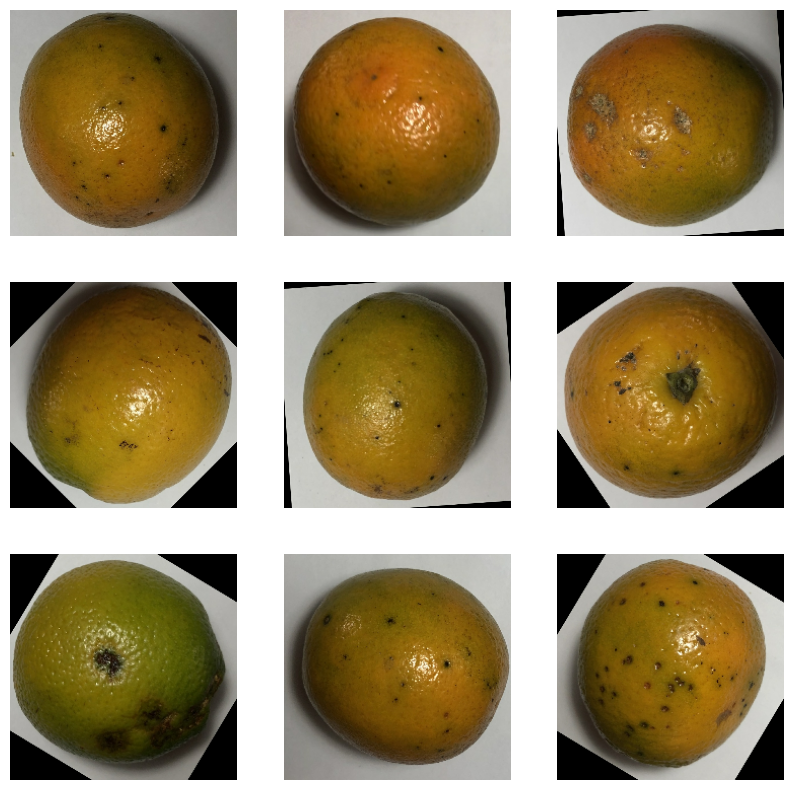

In [10]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))  # Ahora se verá bien
    plt.axis("off")
plt.show()

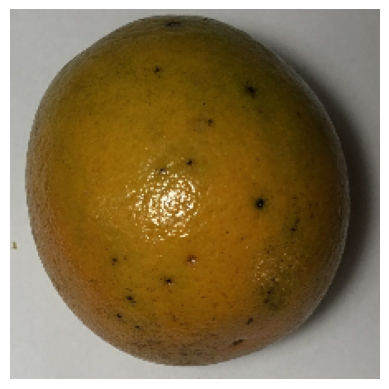

In [11]:
plt.imshow(image_batch[i].numpy().astype("uint8"))
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.axis("off")
plt.show()

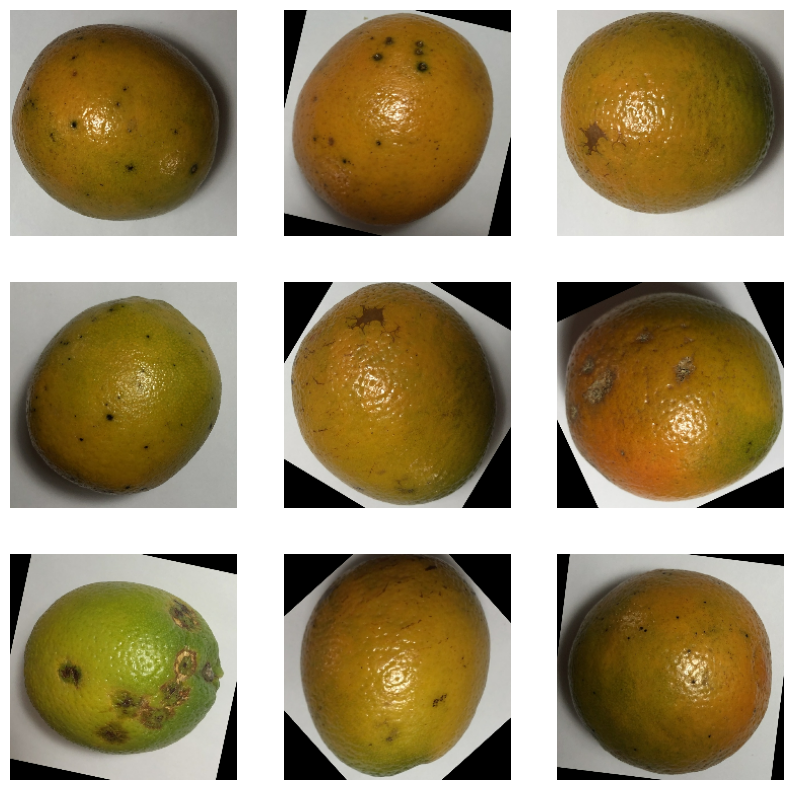

In [12]:

# Obtener un batch de imágenes
image_batch, label_batch = next(iter(train_data))

# Mostrar algunas imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))  # Asegura que los valores sean correctos
    plt.axis("off")
plt.show()


In [13]:
# Cargar VGG16 preentrenado sin la parte superior (fully connected layers)
base_model = keras.applications.VGG16(input_shape=(224,224, 3), include_top=False, weights="imagenet")

# Congelar el modelo base
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model = models.Sequential([
    layers.Rescaling(1./255),  # Normalización en el modelo
    layers.RandomFlip("horizontal"),  # Augmentación
    layers.RandomRotation(0.1),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Capa binaria
])

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_data, epochs=15, validation_data=val_data)


Epoch 1/15
45/64 ━━━━━━━━━━━━━━━━━━━━ 6:33 21s/step - accuracy: 0.7031 - loss: 0.6297

In [ ]:
# Descongelar algunas capas para fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Mantener congeladas todas excepto las 10 últimas
    layer.trainable = False

In [ ]:
# Recompilar el modelo con una tasa de aprendizaje menor
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar con fine-tuning
history_fine = model.fit(train_data, epochs=5, validation_data=val_data)

In [ ]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(val_data, verbose=2)
print("Accuracy en validación:", test_acc)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Guardar los nombres de las clases ANTES de hacer .map()
print("Clases:", class_names)

# Inicializar listas
y_true = []
y_pred = []

# Obtener etiquetas verdaderas y predicciones
for images, labels in val_data:
    y_true.extend(labels.numpy().flatten())  # Convertir a lista

    # Predecir y aplicar umbral (ya que usamos 'sigmoid')
    predictions = model.predict(images)
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Imprimir el reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_names))


In [1]:

from tensorflow.keras.preprocessing import image

# Ruta de la imagen a probar
img_path = "/content/drive/MyDrive/dataset/test/citrus-canker/citrus-canker (180).jpg"

# Cargar y preprocesar la imagen
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0  # Normalizar
img_array = np.expand_dims(img_array, axis=0)

# Hacer predicción
pred = model.predict(img_array)[0][0]
pred_class = class_names[1] if pred > 0.5 else class_names[0]

# Mostrar resultado
print(f"La imagen pertenece a la clase: {class_names[pred_class]}")

NameError: name 'IMG_SIZE' is not defined

In [131]:
print("Tamaño de entrada del modelo:", model.input_shape)
print("Probabilidades de salida:", pred)


Tamaño de entrada del modelo: (None, 224, 224, 3)
Probabilidades de salida: [[0.9997434]]


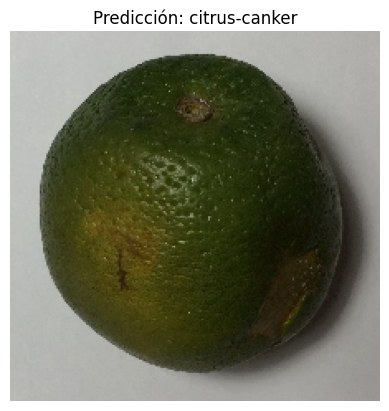

In [124]:
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicción: {class_names[pred_class]}")
plt.show()

# Guardar el modelo
model.save("/content/drive/MyDrive/modelo_final1.h5")